### This script is for validating the approach of WalkEasy

In [1]:
## IMPORT NECESSARY PYTHON MODULES:
from sqlalchemy import create_engine
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [2]:
## CONNECT TO SQL DATABASE:
# Provide database info
dbname = os.environ['dbname']
pswd = os.environ['pswd']
username = os.environ['username']
# construct a connection to a database
engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname))
# connect to the database
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

### Select random sets of 1000 starting and ending locations for validation routing.

In [3]:
id_starts = []
id_ends = []
for i in range(1000):
    id_starts.append([random.uniform(-122.5175,-122.3769), random.uniform(37.7042, 37.8109)])
    id_ends.append([random.uniform(-122.5175,-122.3769), random.uniform(37.7042, 37.8109)])

### Run a loop that calculates the easiest and shortest routes between the 1000 random pairs of start/end locations.

In [4]:
# A loop to calc the total cal_cost and length_ft for a) cal_cost and b) length_ft optimized routes for
# many random sets of start/end ids. 
Validation_vals = []
for i in range(1000):
    
    cur_get_ids_from_ll_start = con.cursor()
    cur_get_ids_from_ll_end = con.cursor()
    cur_get_ids_from_ll_start.execute("""select id from ways_vertices_pgr order by st_distance(the_geom, st_setsrid(st_makepoint(%s, %s), 4326)) limit 1;""", (id_starts[i][0], id_starts[i][1]))
    cur_get_ids_from_ll_end.execute("""select id from ways_vertices_pgr order by st_distance(the_geom, st_setsrid(st_makepoint(%s, %s), 4326)) limit 1;""", (id_ends[i][0], id_ends[i][1]))

    start_id = cur_get_ids_from_ll_start.fetchall()
    end_id = cur_get_ids_from_ll_end.fetchall()
    
    if start_id != end_id:
            cur_easy = con.cursor()
            cur_easy.execute("""SELECT id, lon, lat, route.cost, route.edge, new_ways.length_ft, new_ways.cal_cost
               FROM ways_vertices_pgr
               JOIN
               (SELECT * FROM pgr_dijkstra('
                SELECT gid AS id,
                     source,
                     target,
                     cal_cost AS cost,
                     length_ft,
                     cal_cost
                    FROM ways_act_cals',
                %s, %s, directed := false )) AS route
               ON
               ways_vertices_pgr.id = route.node
               JOIN (SELECT gid, length_ft, cal_cost FROM ways_act_cals) AS new_ways
               ON new_ways.gid = route.edge
               ORDER BY seq;""", (start_id, end_id))
            Easy_Path = cur_easy.fetchall()

            cur_short = con.cursor()
            cur_short.execute("""SELECT id, lon, lat, route.cost, route.edge, new_ways.length_ft, new_ways.cal_cost
               FROM ways_vertices_pgr
               JOIN
               (SELECT * FROM pgr_dijkstra('
                SELECT gid AS id,
                     source,
                     target,
                     length_ft AS cost,
                     length_ft,
                     cal_cost
                    FROM ways_act_cals',
                %s, %s, directed := false )) AS route
               ON
               ways_vertices_pgr.id = route.node
               JOIN (SELECT gid, length_ft, cal_cost FROM ways_act_cals) AS new_ways
               ON new_ways.gid = route.edge
               ORDER BY seq;""", (start_id, end_id))
            Short_Path = cur_short.fetchall()


            Easy_Total_Cal = 0
            Easy_Total_Dist = 0
            for i in range(len(Easy_Path)):
                Easy_Total_Cal += Easy_Path[i][6]
                Easy_Total_Dist += Easy_Path[i][5]

            Short_Total_Cal = 0
            Short_Total_Dist = 0
            for i in range(len(Short_Path)):
                Short_Total_Cal += Short_Path[i][6]
                Short_Total_Dist += Short_Path[i][5]    

            #Need to record the four totals above for each iteration in the loop 
            Validation_vals.append([Easy_Total_Cal, Easy_Total_Dist, Short_Total_Cal, Short_Total_Dist])



In [ ]:
#Validation_vals

In [33]:
np.savetxt('Validation_act_vals_easycal_easydist_shortcal_shortdist.txt', Validation_vals, fmt='%d')

### Remove any zero rows (where routes were not found; very rare)

In [25]:
Val_array = np.asarray(Validation_vals)
Val_array
Val_array = Val_array[~np.all(Val_array == 0, axis=1)]

### Compare Means of Cals (Easiest vs. Shortest) 

In [27]:
from scipy import stats

# Compare cals for easy vs short
stats.ks_2samp(Val_array[:,0], Val_array[:,2])

Ks_2sampResult(statistic=0.07272727272727264, pvalue=0.01002979930693737)

### Compare Means of Dist (Easiest vs. Shortest)

In [ ]:
stats.ks_2samp(Val_array[:,1], Val_array[:,3])

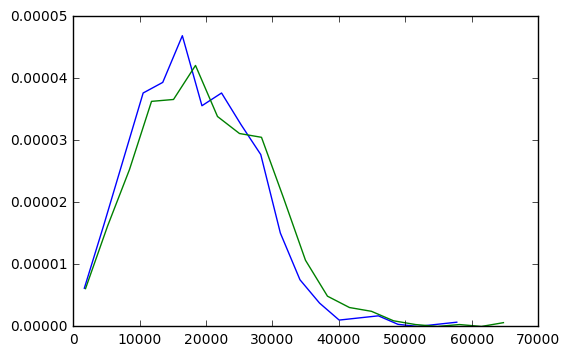

In [8]:
hist, bins = np.histogram(Val_array[:,0], bins=20, normed=True)
bin_centers = (bins[1:]+bins[:-1])*0.5
plt.plot(bin_centers, hist)
hist1, bins1 = np.histogram(Val_array[:,2], bins=20, normed=True)
bin_centers1 = (bins1[1:]+bins1[:-1])*0.5
plt.plot(bin_centers1, hist1)
plt.show()

In [ ]:
from scipy.stats.kde import gaussian_kde
from numpy import linspace

# this create the kernel, given an array it will estimate the probability over that values
kde_easy = gaussian_kde(Val_array[:,0])
kde_short = gaussian_kde(Val_array[:,2])
# these are the values over wich your kernel will be evaluated
cal_space_easy = linspace( min(Val_array[:,0]), max(Val_array[:,0]), 100 )
cal_space_short = linspace( min(Val_array[:,2]), max(Val_array[:,2]), 100 )
# plot the results
plt.plot( cal_space_easy, kde_easy(cal_space_easy) )
plt.plot( cal_space_short, kde_easy(cal_space_short) )
plt.show()

In [9]:
Val_diffs_cals = Val_array[:,2] - Val_array[:,0] # Cals short - Cals easy (should be positive)
Val_diffs_dist = Val_array[:,1] - Val_array[:,3] # Dist easy - Dist short (should be positve)


In [10]:
Val_diffs_cals.mean()

1463.6666666666667

In [11]:
Val_diffs_dist.mean()

1057.5366589015239

### Boxplots of validation measures

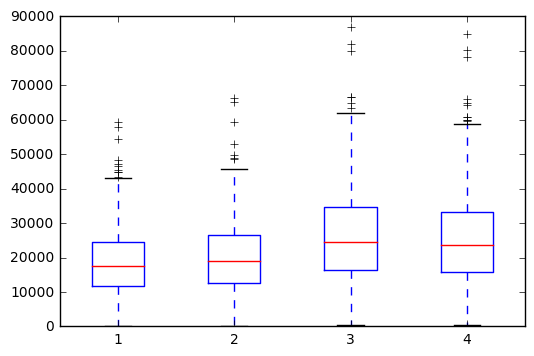

In [14]:
plt.boxplot([Val_array[:,0], Val_array[:,2], Val_array[:,1], Val_array[:,3]])
plt.show()

### Plot CDFs of Calorie burn for Easiest vs. Shortest routes

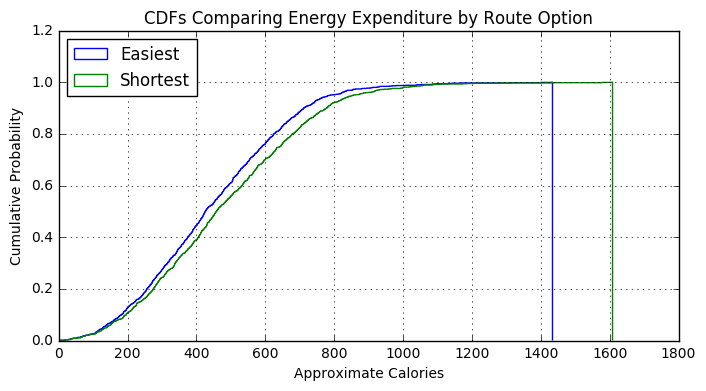

In [24]:
#Good, except the x-axis label/range
fig, ax = plt.subplots(figsize=(8, 4))

x = Val_array[:,0]*80.7*0.0003
y = Val_array[:,2]*80.7*0.0003

n_bins = 1000
# plot the cumulative histogram
n, bins, patches = ax.hist(x, n_bins, normed=1, histtype='step',
                           cumulative=True, label='Easiest')
n, bins, patches = ax.hist(y, n_bins, normed=1, histtype='step',
                           cumulative=True, label='Shortest')

# tidy up the figure
ax.grid(True)
ax.legend(loc=2)
ax.set_title('CDFs Comparing Energy Expenditure by Route Option')
ax.set_xlabel('Approximate Calories')
ax.set_ylabel('Cumulative Probability')

plt.show()

### Plot CDFs of Calorie burn for Easiest vs. Shortest routes

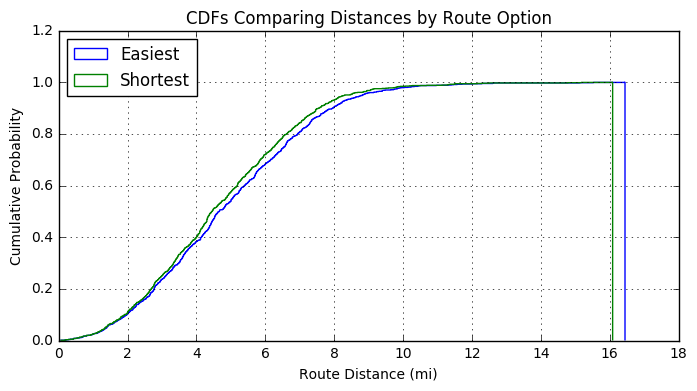

In [16]:
fig, ax = plt.subplots(figsize=(8, 4))

x = Val_array[:,1]/5280
y = Val_array[:,3]/5280
n_bins = 1000
# plot the cumulative histogram
n, bins, patches = ax.hist(x, n_bins, normed=1, histtype='step',
                           cumulative=True, label='Easiest')
n, bins, patches = ax.hist(y, n_bins, normed=1, histtype='step',
                           cumulative=True, label='Shortest')

# Overlay a reversed cumulative histogram.
#ax.hist(x, bins=bins, normed=1, histtype='step', cumulative=-1,
#        label='Reversed emp.')

# tidy up the figure
ax.grid(True)
ax.legend(loc=2)
ax.set_title('CDFs Comparing Distances by Route Option')
ax.set_xlabel('Route Distance (mi)')
ax.set_ylabel('Cumulative Probability')

plt.show()

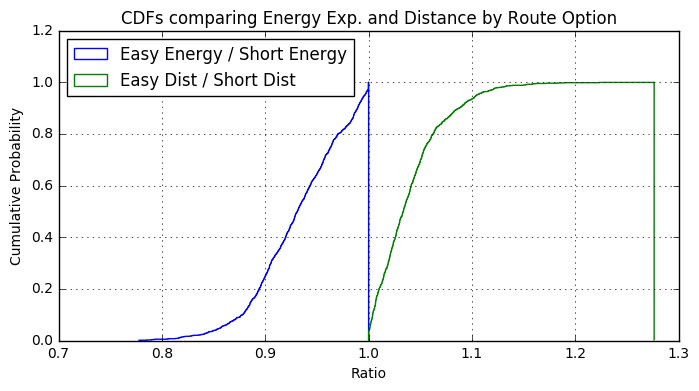

In [17]:
#Also Good, but less so (more confusing)
fig, ax = plt.subplots(figsize=(8, 4))

x = Val_array[:,0]/Val_array[:,2]
y = Val_array[:,1]/Val_array[:,3]
n_bins = 1000
# plot the cumulative histogram
n, bins, patches = ax.hist(x, n_bins, normed=1, histtype='step',
                           cumulative=True, label='Easy Energy / Short Energy')
n, bins, patches = ax.hist(y, n_bins, normed=1, histtype='step',
                           cumulative=True, label='Easy Dist / Short Dist')

# Overlay a reversed cumulative histogram.
#ax.hist(x, bins=bins, normed=1, histtype='step', cumulative=-1,
#        label='Reversed emp.')

# tidy up the figure
ax.grid(True)
ax.legend(loc=2)
ax.set_title('CDFs comparing Energy Exp. and Distance by Route Option')
ax.set_xlabel('Ratio')
ax.set_ylabel('Cumulative Probability')

plt.show()

In [18]:
np.where(x == 1)


(array([ 12,  74, 207, 232, 304, 322, 376, 403, 461, 524, 560, 576, 594,
        596, 628, 697, 706, 777, 792, 866, 907, 927, 928, 960, 967, 969]),)

In [ ]:
num_same_routes = 26
percent_same_routes = 2.6

### Calculate average percent Calorie savings for Easiest vs. Shortest routes

In [28]:
# Also want:
# Average % energy savings (ks -test to back up)
# Average % length increase (ks -test to back up)
Energy_Savings = (Val_array[:,2]-Val_array[:,0])/Val_array[:,2]
Energy_Savings.mean()

0.069543268049172061

### Calculate average percent Distance cost for Easiest vs. Shortest routes

In [29]:
Distance_cost = (Val_array[:,1]-Val_array[:,3])/Val_array[:,1]
Distance_cost.mean()

0.037759803221169806

In [32]:
from scipy import stats
stats.ttest_ind(Val_array[:,0],Val_array[:,2])


Ttest_indResult(statistic=-3.5374404072922085, pvalue=0.00041333704054582408)